# Wheelchair Rugby Analysis: Canada Lineup Optimization

## Objective
This notebook analyzes wheelchair rugby line-up data to optimize Team Canada's player combinations. We aim to find the best 4-player lineups (constrained by the 8.0 classification point limit) that maximize Goal Differential relative to opponents.

## Methodology
1. **Data Preprocessing**: Weight stints by duration to account for endurance.
2. **Exploratory Data Analysis (EDA)**: Visualize stint durations, team performance, and correlations.
3. **Global Player Ratings**: Use Weighted Ridge Regression to estimate individual player impact (Net Rating).
4. **Canada Scoring Model**: Predict Canada's offensive output based on lineups and opponent strength.
5. **Optimization**: Generate and rank valid lineups based on predicted performance.


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from itertools import combinations

# Setup plotting style
sns.set_theme(style="whitegrid")
%matplotlib inline

In [34]:
# Load Data
stints_path = 'stint_data.csv'
players_path = 'player_data.csv'

try:
    stints = pd.read_csv(stints_path)
    players = pd.read_csv(players_path)
    print("Data Loaded Successfully.")
    print(f"Stints Shape: {stints.shape}")
    print(f"Players Shape: {players.shape}")
except FileNotFoundError:
    print("Error: CSV files not found. Please ensure 'stint_data.csv' and 'player_data.csv' are in the same directory.")
    
# Display first few rows
stints.head()

Data Loaded Successfully.
Stints Shape: (7448, 14)
Players Shape: (144, 2)


,game_id,h_team,a_team,minutes,h_goals,a_goals,home1,home2,home3,home4,away1,away2,away3,away4
0,1,USA,Japan,4.252969,4,9,USA_p4,USA_p1,USA_p3,USA_p6,Japan_p12,Japan_p4,Japan_p8,Japan_p6
1,1,USA,Japan,5.688809,6,11,USA_p1,USA_p7,USA_p6,USA_p5,Japan_p7,Japan_p10,Japan_p8,Japan_p12
2,1,USA,Japan,1.149557,0,1,USA_p8,USA_p1,USA_p4,USA_p5,Japan_p5,Japan_p3,Japan_p7,Japan_p10
3,1,USA,Japan,3.511617,7,5,USA_p2,USA_p7,USA_p8,USA_p6,Japan_p2,Japan_p4,Japan_p10,Japan_p12
4,1,USA,Japan,2.163139,7,5,USA_p9,USA_p5,USA_p8,USA_p7,Japan_p8,Japan_p6,Japan_p10,Japan_p1


## Exploratory Data Analysis (EDA)

Before modeling, let's understand the data distribution. Key factors include stint duration and team performance.

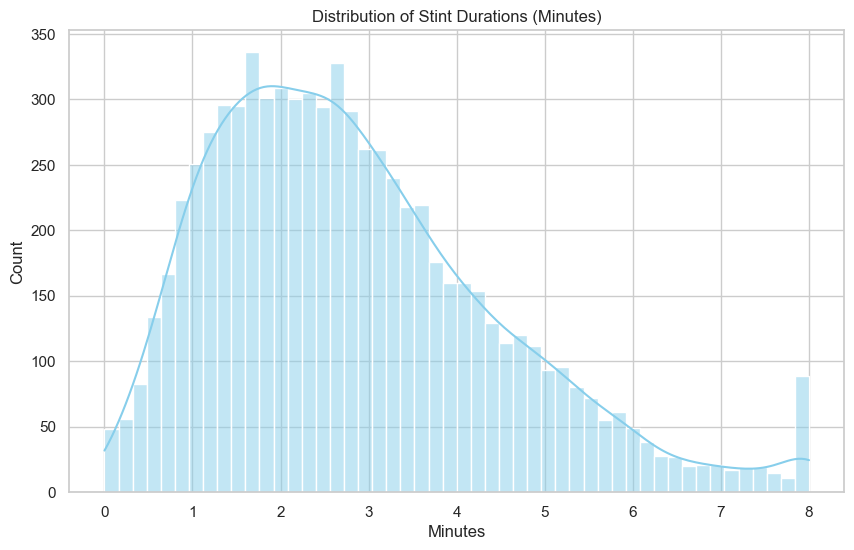

Mean Stint Duration: 2.84 min
Median Stint Duration: 2.58 min


In [35]:
# 1. Distribution of Stint Durations
plt.figure(figsize=(10, 6))
sns.histplot(stints['minutes'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Stint Durations (Minutes)')
plt.xlabel('Minutes')
plt.show()

print(f"Mean Stint Duration: {stints['minutes'].mean():.2f} min")
print(f"Median Stint Duration: {stints['minutes'].median():.2f} min")

<Figure size 1200x800 with 0 Axes>

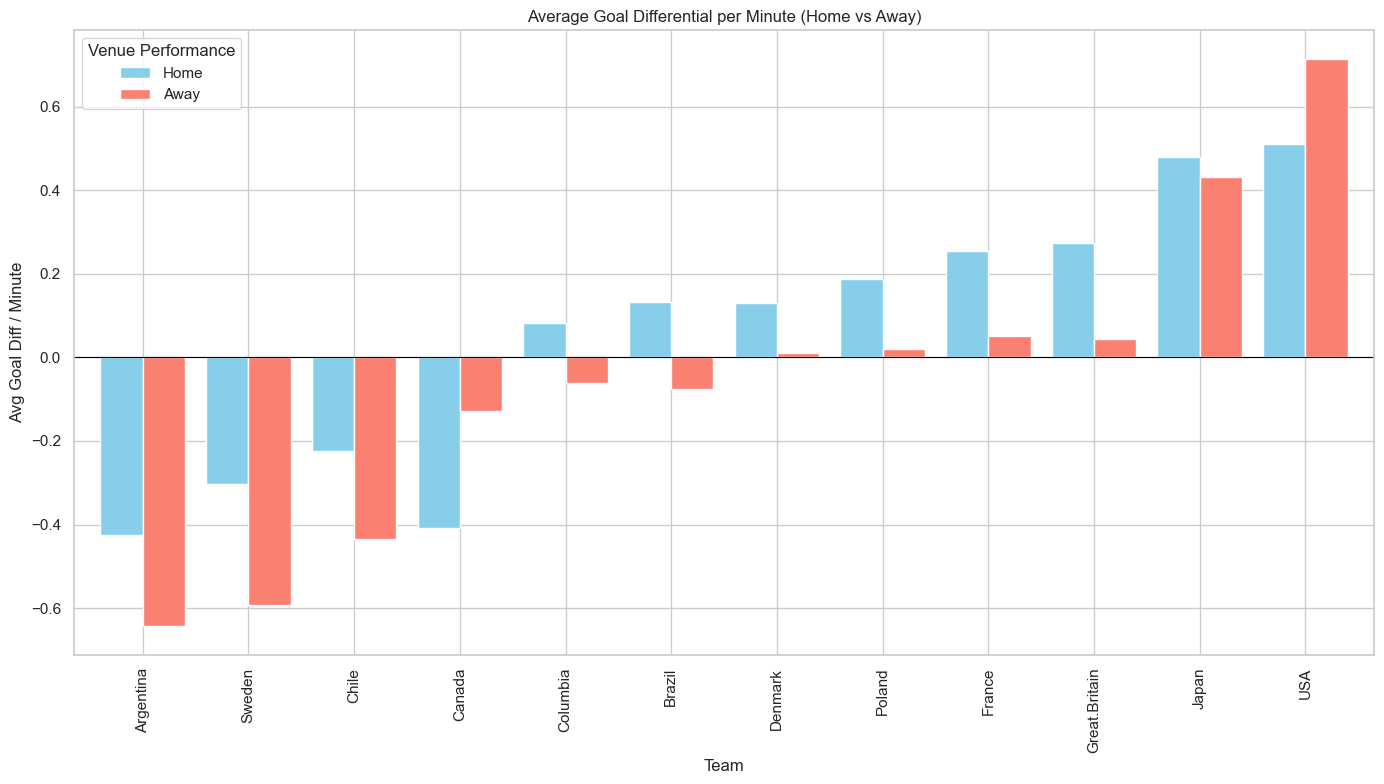

Canada Performance:
 Home: -0.409
 Away: -0.128
 Total Index: -0.537


In [36]:
# 2. Team Performance (Avg Goal Diff per Minute - Home vs Away)
# Pre-calculate per-minute stats for EDA
stints['goal_diff'] = stints['h_goals'] - stints['a_goals']
stints['goal_diff_per_min'] = stints['goal_diff'] / stints['minutes']

# Calculate Home Performance (Positive is good for Home)
home_perf = stints.groupby('h_team')['goal_diff_per_min'].mean()

# Calculate Away Performance (Negative goal_diff is good for Away, so we invert it)
away_perf = stints.groupby('a_team')['goal_diff_per_min'].mean() * -1

# Merge into a single DataFrame
team_stats = pd.DataFrame({'Home': home_perf, 'Away': away_perf})
team_stats['Total'] = team_stats['Home'].fillna(0) + team_stats['Away'].fillna(0)

# Sort by Total Performance for order
team_stats = team_stats.sort_values(by='Total', ascending=True)

# Plot Parallel (Side-by-Side) Bar Chart
plt.figure(figsize=(12, 8))
# stacked=False creates side-by-side bars
team_stats[['Home', 'Away']].plot(kind='bar', stacked=False, figsize=(14, 8), color=['skyblue', 'salmon'], width=0.8)

plt.title('Average Goal Differential per Minute (Home vs Away)')
plt.xlabel('Team')
plt.ylabel('Avg Goal Diff / Minute')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend(title='Venue Performance')
plt.tight_layout()
plt.show()

# Highlight Canada's Stats
if 'Canada' in team_stats.index:
    print(f"Canada Performance:\n Home: {team_stats.loc['Canada', 'Home']:.3f}\n Away: {team_stats.loc['Canada', 'Away']:.3f}\n Total Index: {team_stats.loc['Canada', 'Total']:.3f}")

## Data Preprocessing

We filter out very short stints (artifacts) and create the necessary calculated columns.

In [21]:
# Filter artifacts
stints = stints[stints['minutes'] > 0.01].copy()

# Recalculate metrics ensures consistency
stints['goal_diff'] = stints['h_goals'] - stints['a_goals']
stints['goal_diff_per_min'] = stints['goal_diff'] / stints['minutes']
stints['h_goals_per_min'] = stints['h_goals'] / stints['minutes']
stints['a_goals_per_min'] = stints['a_goals'] / stints['minutes']

print(f"Valid Stints after filtering: {len(stints)}")

Valid Stints after filtering: 7444


## Model 1: Global Player Ratings

We use a **Weighted Ridge Regression** to decouple individual player impact from their teammates.
- **Target**: Goal Differential per Minute
- **Features**: Sparse matrix of players (Home=+1, Away=-1)
- **Weights**: Stint duration (Minutes)


In [22]:
# Create Player Matrix
home_cols = ['home1', 'home2', 'home3', 'home4']
away_cols = ['away1', 'away2', 'away3', 'away4']

all_players = set()
for col in home_cols + away_cols:
    all_players.update(stints[col].unique())

all_players = sorted(list(all_players))
player_to_idx = {p: i for i, p in enumerate(all_players)}

# Construct Sparse-like Matrix
data = []
for idx, row in stints.iterrows():
    row_data = np.zeros(len(all_players))
    # Home (+1)
    for col in home_cols:
        if row[col] in player_to_idx:
            row_data[player_to_idx[row[col]]] = 1.0
    # Away (-1)
    for col in away_cols:
        if row[col] in player_to_idx:
            row_data[player_to_idx[row[col]]] = -1.0
    data.append(row_data)

X = pd.DataFrame(data, columns=all_players, index=stints.index)
y = stints['goal_diff_per_min']
weights = stints['minutes']

print(f"Feature Matrix Shape: {X.shape}")

Feature Matrix Shape: (7444, 144)


In [23]:
# Train Global Model
ridge = Ridge(alpha=1.0, fit_intercept=False)
ridge.fit(X, y, sample_weight=weights)

# Extract Ratings
player_net_ratings = pd.Series(ridge.coef_, index=all_players)

print("--- Top 10 Players by Net Rating (Global) ---")
print(player_net_ratings.sort_values(ascending=False).head(10))

--- Top 10 Players by Net Rating (Global) ---
Denmark_p8          0.872787
France_p10          0.679870
Japan_p12           0.651161
Great.Britain_p2    0.631598
Brazil_p1           0.591166
France_p11          0.526416
Canada_p11          0.478075
Brazil_p8           0.462143
Canada_p9           0.453974
Brazil_p12          0.434274
dtype: float64


## Model 2: Canada Scoring Optimization

We focus specifically on **Canada's offensive efficiency**.
We train a model to predict `Canada Goals / Minute` using:
1. **Canada Players** (Binary indicators)
2. **Opponent Strength** (Sum of Opponent Net Ratings from Model 1)


In [24]:
# Prepare Canada-specific data
ratings_dict = player_net_ratings.to_dict()

def get_opp_rating_sum(row, is_canada_home):
    opp_cols = ['away1', 'away2', 'away3', 'away4'] if is_canada_home else ['home1', 'home2', 'home3', 'home4']
    return sum(ratings_dict.get(row[c], 0) for c in opp_cols)

def get_canada_players(row, is_canada_home):
    cols = ['home1', 'home2', 'home3', 'home4'] if is_canada_home else ['away1', 'away2', 'away3', 'away4']
    return [row[c] for c in cols]

# Filter Canada Games
canada_home = stints[stints['h_team'] == 'Canada'].copy()
canada_away = stints[stints['a_team'] == 'Canada'].copy()

canada_home['is_home'] = 1
canada_home['canada_goals_pm'] = canada_home['h_goals_per_min']
canada_home['opp_strength'] = canada_home.apply(lambda r: get_opp_rating_sum(r, True), axis=1)

canada_away['is_home'] = 0
canada_away['canada_goals_pm'] = canada_away['a_goals_per_min']
canada_away['opp_strength'] = canada_away.apply(lambda r: get_opp_rating_sum(r, False), axis=1)

combined_can = pd.concat([canada_home, canada_away])

# Identify Canada unique players
can_players_set = set()
for cols in [home_cols, away_cols]:
    for p in combined_can[cols].values.flatten():
        if isinstance(p, str) and "Canada" in p:
            can_players_set.add(p)
can_players_list = sorted(list(can_players_set))

# Build Canada Feature Matrix
X_can_data = []
for idx, row in combined_can.iterrows():
    feats = {p: 0 for p in can_players_list}
    current_sq = get_canada_players(row, row['is_home'] == 1)
    for p in current_sq:
        if p in feats:
            feats[p] = 1
    feats['opp_strength'] = row['opp_strength']
    X_can_data.append(feats)

X_can = pd.DataFrame(X_can_data)
y_can = combined_can['canada_goals_pm']
w_can = combined_can['minutes']

# Train Model
can_model = Ridge(alpha=1.0, fit_intercept=True)
can_model.fit(X_can, y_can, sample_weight=w_can)

print("Canada Model Trained.")
print(f"Base Scoring Rate (Intercept): {can_model.intercept_:.4f} goals/min")

Canada Model Trained.
Base Scoring Rate (Intercept): 1.6296 goals/min


## Lineup Optimization

We generate all valid 4-player combinations for Team Canada that satisfy the classification rule:
**Total Class Points <= 8.0**

We prioritize lineups by their **Predicted Goals per Minute**.


In [25]:
# Interactive Lineup Optimization
# -------------------------------
# Input Opponent details to tailor the ranking.
# If left blank, we assume an average opponent (Strength = 0).

# 1. Load Classification Ratings
# Assumes player_data.csv has columns 'player' and 'rating'
class_dict = dict(zip(players['player'], players['rating']))

# 2. Extract Coefficients from Trained Model
feature_names = X_can.columns.tolist()
player_coefs = {name: can_model.coef_[i] for i, name in enumerate(feature_names)}
# We also need the coefficient for the 'opp_strength' feature itself
# feature_names includes specific player columns + 'opp_strength'
opp_strength_coef = player_coefs.get('opp_strength', 0.0)

# 3. User Input for Opponent
print("\n--- Opponent Configuration ---")
opp_country = input("Enter Opponent Country (e.g., USA) [Press Enter for Average Team]: ").strip()

current_opp_strength = 0.0

if not opp_country:
    print("No opponent specified. Assuming average opponent strength = 0 for raw potential.")
else:
    opp_nums_str = input("Enter 4 Opponent Player Numbers (e.g., 1, 4, 12, 8) [Press Enter for Average Team]: ").strip()
    if not opp_nums_str:
        print(f"No player numbers provided for {opp_country}. Assuming average strength = 0.")
    else:
        # Construct IDs and Calculate Strength
        # IDs are formatted like 'Country_pNumber' (e.g. USA_p1)
        try:
            opp_ids = [f"{opp_country}_p{num.strip()}" for num in opp_nums_str.split(',')]
            # Sum rating from the Global Model (ratings_dict)
            # Note: ratings_dict keys must match the ID format
            current_opp_strength = sum(ratings_dict.get(pid, 0.0) for pid in opp_ids)
            
            print(f"\nOpponent: {opp_country} | Players: {opp_ids}")
            print(f"Calculated Opponent Strength (Net Rating Sum): {current_opp_strength:.4f}")
        except Exception as e:
            print(f"Error parsing players: {e}. Defaulting to strength 0.")
            current_opp_strength = 0.0

# 4. Generate and Rank Lineups
can_squad = [f for f in feature_names if f != 'opp_strength']
combos = list(combinations(can_squad, 4))
valid_lineups = []

# print(f"Evaluating {len(combos)} possible lineups against Opponent Strength {current_opp_strength:.2f}...")

for lineup in combos:
    # Check constraint: Total Class <= 8.0
    total_class = sum(class_dict.get(p, 0) for p in lineup)
    
    if total_class <= 8.0:
        # Predict Scoring Rate
        # Formula: Intercept + Sum(Player Coefs) + (OppStrength * OppCoef)
        can_player_sum = sum(player_coefs.get(p, 0) for p in lineup)
        
        pred_gpm = can_model.intercept_ + can_player_sum + (current_opp_strength * opp_strength_coef)
        
        valid_lineups.append({
            'lineup': lineup,
            'total_class': total_class,
            'pred_goals_per_min': pred_gpm,
            'pred_goals_per_8min': pred_gpm * 8
        })

# Sort Results
valid_lineups.sort(key=lambda x: x['pred_goals_per_min'], reverse=True)

# Display Top 10
results_df = pd.DataFrame(valid_lineups)
if not results_df.empty:
    # Clean up names for display
    results_df['lineup_clean'] = results_df['lineup'].apply(lambda x: ", ".join([p.replace("Canada_", "") for p in x]))

    print("\nTop 10 Recommended Lineups:")
    display(results_df[['lineup_clean', 'total_class', 'pred_goals_per_min', 'pred_goals_per_8min']].head(10))
else:
    print("No valid lineups found (check classification data).")


--- Opponent Configuration ---


Enter Opponent Country (e.g., USA) [Press Enter for Average Team]:  USA
Enter 4 Opponent Player Numbers (e.g., 1, 4, 12, 8) [Press Enter for Average Team]:  1, 2, 3, 4



Opponent: USA | Players: ['USA_p1', 'USA_p2', 'USA_p3', 'USA_p4']
Calculated Opponent Strength (Net Rating Sum): 0.1043

Top 10 Recommended Lineups:


,lineup_clean,total_class,pred_goals_per_min,pred_goals_per_8min
0,"p11, p2, p5, p9",8.0,2.155767,17.246138
1,"p11, p2, p8, p9",8.0,2.058985,16.471877
2,"p11, p2, p7, p9",7.5,2.040121,16.320966
3,"p1, p11, p2, p9",7.5,2.020447,16.163575
4,"p11, p2, p3, p9",6.5,1.915960,15.327679
5,"p2, p3, p5, p9",8.0,1.913879,15.311036
6,"p11, p2, p6, p9",6.0,1.868583,14.948663
7,"p2, p5, p6, p9",7.5,1.866502,14.932020
8,"p10, p11, p2, p9",5.5,1.853172,14.825377
9,"p10, p2, p5, p9",7.0,1.851092,14.808734


/var/folders/vb/xwbqv9pd6wjb16g61t0mf7bm0000gn/T/ipykernel_16452/2274702165.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, y='lineup_clean', x='pred_goals_per_min', palette='viridis')


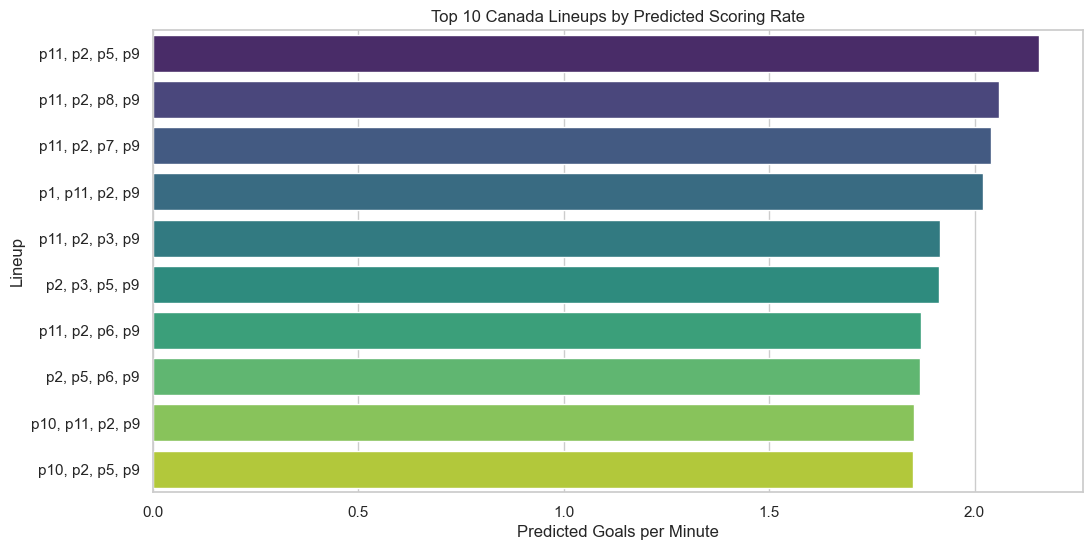

In [26]:
# Visualize Top 10 Lineups
top_10 = results_df.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10, y='lineup_clean', x='pred_goals_per_min', palette='viridis')
plt.title('Top 10 Canada Lineups by Predicted Scoring Rate')
plt.xlabel('Predicted Goals per Minute')
plt.ylabel('Lineup')
plt.show()

## Canada Player Rankings by Role

We rank Canadian players based on their **Net Rating (Ridge Regression Coefficient)** and **Raw Plus-Minus per Minute**.
Players are categorized by their classification score:
- **Attacker**: Class >= 2.5
- **Flex**: 1.0 < Class < 2.5
- **Defense**: Class <= 1.0

In [28]:
# 1. Calculate Raw Net Rating (Plus-Minus) per Minute
player_raw_stats = {}

for p in can_players_list:
    # Find stints where player p was on the court
    # Check all 8 player columns
    mask = (stints[home_cols + away_cols] == p).any(axis=1)
    p_stints = stints[mask]
    
    total_goal_diff = 0
    total_mins = p_stints['minutes'].sum()
    
    # Determine if player was Home or Away for each stint to interpret goal_diff correctly
    # goal_diff is (Home - Away). If player is Home, +GD is good. If Away, -GD is good.
    # Simplification: We already standardized data earlier or we can just iterate carefully.
    
    # Let's iterate to be safe given mixed usage
    for _, row in p_stints.iterrows():
        # Goal Diff from Home perspective
        gd = row['h_goals'] - row['a_goals']
        
        # Check if player is Home or Away
        if p in row[home_cols].values:
            total_goal_diff += gd
        else:
            total_goal_diff -= gd # Negative of (Home - Away) is (Away - Home)
            
    raw_pm_per_min = total_goal_diff / total_mins if total_mins > 0 else 0
    player_raw_stats[p] = raw_pm_per_min

# 2. Create Combined DataFrame
rank_data = []
for p in can_players_list:
    cls = class_dict.get(p, 0.0)
    net_rating = ratings_dict.get(p, 0.0)
    raw_pm = player_raw_stats.get(p, 0.0)
    
    role = 'Unknown'
    if cls >= 2.5:
        role = 'Attacker'
    elif cls > 1.0:
        role = 'Flex'
    else:
        role = 'Defense'
        
    rank_data.append({
        'Player': p.replace('Canada_', ''),
        'Class': cls,
        'Role': role,
        'Net Rating (Reg)': net_rating,
        'Raw +/- per Min': raw_pm
    })
    
rank_df = pd.DataFrame(rank_data)

# 3. Display Rankings per Role
roles = ['Attacker', 'Flex', 'Defense']

for role in roles:
    print(f"--- {role} Rankings ---")
    subset = rank_df[rank_df['Role'] == role].sort_values(by='Net Rating (Reg)', ascending=False).reset_index(drop=True)
    subset.index += 1
    display(subset)


--- Attacker Rankings ---


,Player,Class,Role,Net Rating (Reg),Raw +/- per Min
1,p9,2.5,Attacker,0.453974,0.343405
2,p7,3.0,Attacker,0.152141,0.079410
3,p5,3.5,Attacker,0.131092,0.022532
4,p8,3.5,Attacker,0.021513,-0.106519
5,p1,3.0,Attacker,-0.009511,-0.072691


--- Flex Rankings ---


,Player,Class,Role,Net Rating (Reg),Raw +/- per Min
1,p11,2.0,Flex,0.478075,0.320752
2,p3,2.0,Flex,0.139476,0.190389
3,p6,1.5,Flex,-0.094614,0.030061
4,p4,2.0,Flex,-0.321093,-0.146066


--- Defense Rankings ---


,Player,Class,Role,Net Rating (Reg),Raw +/- per Min
1,p10,1.0,Defense,-0.206339,-0.012950
2,p2,0.0,Defense,-0.235669,0.084117
3,p12,0.5,Defense,-0.343356,-0.043846
